In [2]:
from DecisionScienceFramework.utils import DistFinder
from DecisionScienceFramework.decision import Decision

from scipy.stats import lognorm, beta

C:\Users\perus\AppData\Local\Continuum\Anaconda3\envs\botworks\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Finding parameters for an asymmetric distribution given a 90% CI

This is helpful when an expert will give you a 90% CI and a mean for a particular distribution, and you need to infer its parmeters.  This finds the optimum through a simple hill climbing method.

Optimization terminated successfully.
         Current function value: 0.565085
         Iterations: 82
         Function evaluations: 160
The fit parameters for this lognormal are mu: 0.9068750292439196, s: 0.8554886568419438 
The fit distribution has a mean of 3.5708563830681457 and a 90% CI of (0.6063617093991157, 10.115092842435686).


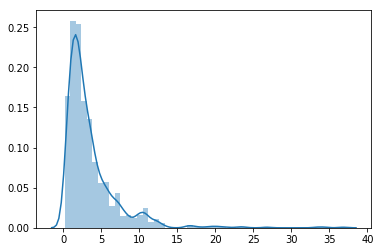

In [3]:
from DecisionScienceFramework.utils import DistFinder
DistFinder(lower=0, upper=10, ev=4, dist=lognorm)

Optimization terminated successfully.
         Current function value: 0.000129
         Iterations: 63
         Function evaluations: 119
The fit parameters for this beta are alpha: 3.665347588181108, beta: 5.702861705722535
The fit distribution has a mean of 0.3912538109675166 and a 90% CI of (0.15576298090844676, 0.6544443370777622).


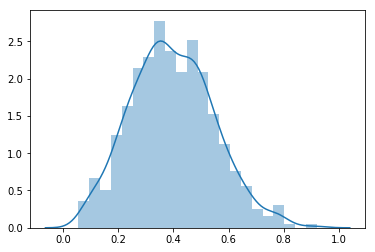

In [5]:
DistFinder(lower=0.15, upper=0.65, ev=0.4, dist=beta)

# Building a decision

In [3]:
# Initialize the decision object with a name and fp where we'll save our progress
school_decision = Decision("School Decision", fp="C:\\Users\\perus\\GitHub\\Decision-Science-Framework")
school_decision.save_state()

## Time to add costs and benefits
Using a basic cost/benefit model can still provide a lot of clarity.  We'll start by adding some 

In [5]:
school_decision.add_variable